In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import re
import datetime as dt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

In [13]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

In [14]:
y = train.QuoteConversion_Flag.values
train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
test = test.drop('QuoteNumber', axis=1)

In [15]:
train.head()

,Field7,Field8,Field9,Field10,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,...,month3,month4,month5,month6,month7,month8,month9,year2013,year2014,year2015
0,23,0.9403,0.0006,965,1.0200,17,23,17,23,15,...,0,0,0,0,0,1,0,1,0,0
1,7,1.0006,0.0040,548,1.2433,6,8,6,8,5,...,0,1,0,0,0,0,0,0,1,0
2,7,1.0006,0.0040,548,1.2433,7,12,7,12,6,...,0,0,0,0,0,1,0,0,1,0
3,10,0.9769,0.0004,1165,1.2665,3,2,3,2,2,...,0,1,0,0,0,0,0,1,0,0
4,23,0.9472,0.0006,1487,1.3045,8,13,8,13,7,...,0,0,0,0,0,0,0,0,1,0


In [16]:
train_mat = xgb.DMatrix(train, label=y)

In [17]:
test_mat = xgb.DMatrix(test)

In [24]:
insample_auc = []
outsample_auc = []
for para in [10, 11, 12, 13, 14, 15, 16]:
    print(para)
    x_train, x_valid, y_train, y_valid = train_test_split(
        train.iloc[:, 1:],
        y,
        test_size=.3,
        random_state=44)
    clf = xgb.XGBClassifier(n_estimators=25,
                            nthread=-1,
                            max_depth=para,
                            learning_rate=0.025,
                            silent=True,
                            subsample=0.8,
                            colsample_bytree=0.8)
    xgb_model = clf.fit(x_train, y_train, eval_metric="auc")
    preds = clf.predict_proba(x_train)[:, 1]
    insample_auc.append(roc_auc_score(y_train, preds))
    preds = clf.predict_proba(x_valid)[:, 1]
    outsample_auc.append(roc_auc_score(y_valid, preds))

10


KeyboardInterrupt: 

In [12]:
xgb.XGBClassifier?

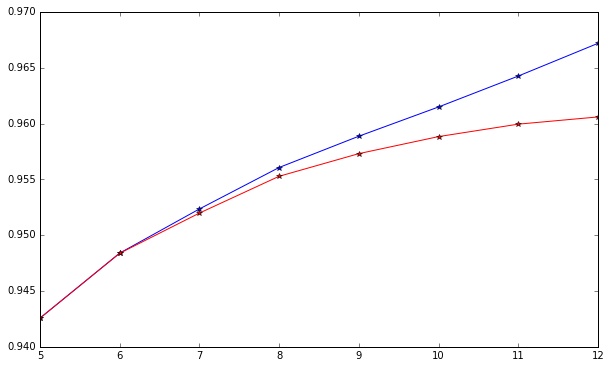

In [11]:
plt.figure(figsize=(10, 6))
plt.subplot(111)
plt.plot([5, 6, 7, 8, 9, 10, 11, 12], insample_auc, marker='*')
plt.plot([5, 6, 7, 8, 9, 10, 11, 12], outsample_auc, marker='*', color='r')

In [20]:
# setup parameters for xgboost
params = {}
# use logistic regression loss
params['objective'] = 'binary:logistic'
params['bst:eta'] = 0.01
params['bst:max_depth'] = 12
params['eval_metric'] = 'auc'
#param['silent'] = 1
params['nthread'] = 4
params['gamma'] = .5
params['alpha'] = .5
params['subsample'] = .8

In [21]:
cv_res = xgb.cv(params=params,
                dtrain=train_mat, 
                num_boost_round=1000, 
                nfold=3,
                show_progress=True,
                early_stopping_rounds=10)

Will train until cv error hasn't decreased in 10 rounds.
[0]	cv-test-auc:0.9542813333333333+0.0009562671639708705	cv-train-auc:0.9582436666666667+0.00045126070316637364
[1]	cv-test-auc:0.9558273333333333+0.0011574343273906343	cv-train-auc:0.9601826666666667+0.0003937802545695697
[2]	cv-test-auc:0.9565416666666667+0.0009246766401769289	cv-train-auc:0.960948+0.0005163745410713744
[3]	cv-test-auc:0.9569136666666666+0.0008968185744929544	cv-train-auc:0.9612469999999999+0.0005354493440093036
[4]	cv-test-auc:0.957127+0.00102595743901331	cv-train-auc:0.9615113333333333+0.0003578196317824364
[5]	cv-test-auc:0.9572799999999999+0.0010112398330762323	cv-train-auc:0.9616859999999999+0.00033675609373353153
[6]	cv-test-auc:0.9573466666666667+0.0009968645288548194	cv-train-auc:0.9617723333333333+0.0003587072467749817
[7]	cv-test-auc:0.9574666666666666+0.0010538248853053617	cv-train-auc:0.9619253333333333+0.0003905622727413509
[8]	cv-test-auc:0.9575406666666666+0.00108605872564771	cv-train-auc:0.96201

In [22]:
cv_res

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.954281,0.000956,0.958244,0.000451


In [5]:
sample = pd.read_csv('sample_submission.csv')
sample.loc[:, 'QuoteConversion_Flag'] = preds
sample.to_csv('xgb_benchmark.csv', index=False)